In [1]:
import os
from tokenize import group
import numpy as np
import pandas as pd
import time
from math import radians, degrees, sin, cos, asin, acos, sqrt, atan2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import plotly.figure_factory as ff
import matplotlib.collections as mcoll
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from geopy.distance import geodesic
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.ticker as mticker
import tcmarkers
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pickle  

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from skimage.measure import regionprops
from sklearn.decomposition import PCA

import scipy.ndimage as ndimage
from scipy.stats import gaussian_kde
from scipy.interpolate import interpn
from scipy.ndimage import binary_dilation, minimum_filter, maximum_filter, label
from scipy import integrate
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg
from scipy.ndimage import uniform_filter

from datetime import datetime, timedelta

# import haversine
from haversine import haversine

import tropycal.tracks as tracks

from numba import jit, prange, njit
from joblib import Parallel, delayed

import itertools    

# from ty_pkg import latlon
from ty_pkg import truncate_colormap, colorline, setup_map, weather_map_contour, contourf_and_save, ep_t, concentric_circles, interpolate_data, set_map
from ty_pkg import latlon_extent, storm_info, haversine_distance, Met, calculate_bearing_position, tc_finder, WindFieldSolver, find_large_groups, weighted_sum

from typing import List, Optional, Union, Tuple, Dict
from tqdm import tqdm

# pangu_dir = r'/home1/jek/Pangu-Weather'
pangu_dir = r'/data03/Pangu_TC_ENS'

pres_list = ['1000','925','850','700','600','500','400','300','250','200','150','100','50']
pres_array = np.array(pres_list, dtype=np.float32)

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

In [2]:
#! 태풍 경로 정보 기존 정보 불러오기
#위경도 지정
lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(100,160,5,45)  
lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


ssv_dict = {}


#태풍 지정
storm_name, storm_year, key_time_list  = 'HINNAMNOR', 2022, ['2022/08/27/00UTC']
# storm_name, storm_year, key_time_list  = 'NORU', 2017, ['2017/07/30/00UTC']
# storm_name, storm_year, key_time_list  = 'DEBBY', 2012, ['2012/06/23/00UTC']                                                                               


if storm_name == 'DEBBY':
    lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(250,310,5,45)  
    lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


surface_factors = []  # 예시: 지표면에서는 'MSLP'만 선택
upper_factors = ['z'] 
if storm_name == 'HINNAMNOR':
    perturation_scale = 0.05
else:
    perturation_scale = 0.1

#예측 시간 지정, 초기 시간 지정, 앙상블 수
predict_interval_list = np.arange(0,24*7+1,6)  
ens_list = range(0,4000)
new_ssv = 'n'           #새로 생성할 것인지 여부, n이면 기존 파일 불러옴
retro_opt = 'td'        #다시 돌아가면서 태풍 추적시 강한 것만 추적하려면 td로

if retro_opt =='td':
    retro_opt = '_td'
else:
    retro_opt = ''
        
#! 태풍 경로 정보 새로 생성하기

for first_str in key_time_list:
    first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
    key_str = first_time.strftime("%m.%d.%HUTC")
    ssv_key = first_time
    surface_factors.sort()
    upper_factors.sort()
    surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
    upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가
    
    datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
    # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])
    storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #태풍 영문명, 년도 입력

    
    # with open(rf'/data03/Pangu_TC_ENS/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'rb') as f:
    with open(rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'rb') as f:
        ssv_dict = pickle.load(f)



'''
ens_idx_list는 전체 4000개 멤버 중에서 key_time에 해당하는 멤버들에 대한 인덱스 리스트

이후에 ens_idx_list에서 group에 속하는 것들은 group_idx_all_list에 저장

group_idx_list는 ens_idx_list에서 해당하는 인덱스를 추출, ens_uv_factor_uv_all에서 group_idx_list로 인덱싱하여 ens_factor_uv를 구함
'''

if storm_name == 'HINNAMNOR':
    key_time = datetime(2022,8,27,0)             #처음 시점 지정
    start_time = datetime(2022,8,28,0)           #분석 시작 시점
    target_time = datetime(2022,8,31,0)           #위치 projection을 구하고자 하는 시간
elif storm_name == 'NORU':
    key_time = datetime(2017,7,30,0)              #처음 시점 지정
    start_time = datetime(2017,7,30,0)            #분석 시작 시점
    target_time = datetime(2017,8,4,0)            #위치 projection을 구하고자 하는 시간
elif storm_name == 'DEBBY':
    key_time = datetime(2012,6,23,0)              #처음 시점 지정
    start_time = datetime(2012,6,24,0)            #분석 시작 시점
    target_time = datetime(2012,6,27,0)            #위치 projection을 구하고자 하는 시간

key_str = key_time.strftime("%m.%d %HUTC")
start_str = start_time.strftime("%m.%d %HUTC")
target_str = target_time.strftime("%m.%d %HUTC")

total_time_range = int((target_time - key_time).total_seconds() / 3600)
start_time_range = int((start_time  - key_time).total_seconds() / 3600)

# 변수 지정
distance_threshold = 0                      #가까운 태풍의 거리
steer_pres = [850,700,600,500,400,300,250]  #steering wind 구할 때 사용하는 고도 바꿀 필요 x
axis_opt = 'quiver'                         #axis 뭘로 잡을지, opt: 위치 상관관계 최대인 axis, tar: 최종 위치의 axis, mid: 중간 위치의 axis, lon: 경도, lat: 위도
data_sign = 'y'                             #기존의 데이터를 사용할 것인지, n이면 새로 구함
time_array = np.arange(start_time_range,total_time_range+1,6)  #예측 시간 범위
if storm_name == 'NORU':
    time_array = np.arange(6, 121, 6)  #Noru는 6시간 단위로만 진행

nearby_sign_name = '_nearby'
altitude = '850_200'
choosen_factor = 'steering_wind'


In [161]:
# Bring data from ensemble members
def process_ens(input_data_dir: str, ens: Union[str, int], predict_interval: str,
                pres_array: np.ndarray = pres_array,
                level: Union[int, float, list, np.ndarray] = 850) -> Tuple[np.ndarray, np.ndarray]:
    upper = np.load(os.path.join(
        f'{input_data_dir}/{ens}/upper/{predict_interval}h.npy',
    )).astype(np.float32)
    # z, q 값 단위 변환
    upper[upper_dict['z']] /= 9.80665
    upper[upper_dict['q']] *= 1000

    # q 적분
    q_all = upper[upper_dict['q'], :]
    q_col = np.trapz(q_all[::-1], x=pres_array[::-1], axis=0)/9.80665/10  # 압력방향 뒤집기(보통 [높은압력, ..., 낮은압력]으로 적분)

    # 레벨별 변수 추출
    if isinstance(level, (int, float)):
        level = [level]
    level = np.array(level, dtype=np.float32)
    level_idx = [np.where(pres_array == lv)[0][0] for lv in level]
    upper_part_level = upper[:, level_idx, :, :]  # Extract variables at requested levels

    return upper_part_level, q_col

def map_gridlines(ax, proj = ccrs.PlateCarree(), font_size = 15, gridline_spaces = 10):
    gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder= 0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': font_size}
    gl.ylabel_style = {'size': font_size}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, gridline_spaces))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, gridline_spaces))

# Compare with ERA5

Number of ensemble members: 3806
Smallest 10 ensemble numbers: [224, 3994, 3413, 1766, 1439, 2932, 192, 3366, 1363, 2319, 2475, 631, 3076, 1716, 793, 742, 2810, 2462, 1517, 674, 1611, 847, 2233, 3763, 1881, 1505, 208, 3284, 2135, 3389, 335, 3584, 3985, 3606, 2027, 1550, 3028, 1289, 910, 2680, 1906, 3520, 623, 2417, 3451, 2872, 1499, 362, 801, 3531]
Largest 10 ensemble numbers: [470, 955, 1806, 2723, 2903, 161, 1391, 256, 3334, 347, 639, 1202, 3610, 3092, 3644, 1787, 2213, 2817, 2795, 419, 1273, 1671, 2306, 1035, 2480, 2112, 2785, 3437, 3765, 2905, 1683, 2556, 21, 3952, 3054, 2356, 2648, 2382, 1124, 1440, 2145, 2173, 3959, 1498, 1904, 1544, 2056, 1848, 1658, 926]


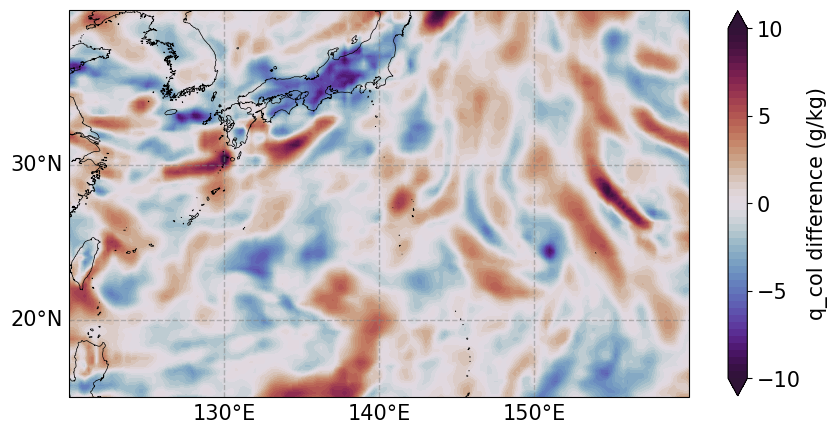

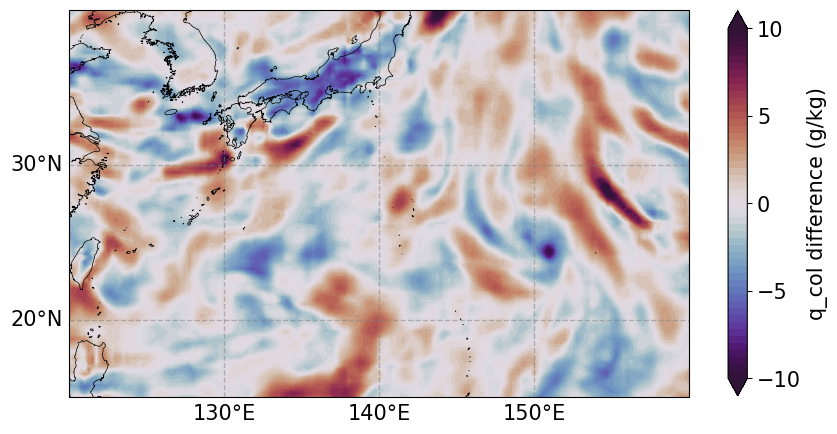

In [144]:
group_size = 50

ens_idx_list = []
    
for ens in ens_list:
    if (target_time in ssv_dict[key_time][ens]):
        ens_idx_list.append(ens)


# 데이터를 추출합니다
# mid_pos = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_idx_list]
tar_pos = [(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_idx_list]
print(f'Number of ensemble members: {len(ens_idx_list)}')
# NumPy 배열로 변환
tar_pos =  np.array(tar_pos)

#타겟 위치의 PCA
corr_pos_tar = np.copy(tar_pos)
corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
pca_tar = PCA(n_components=1)
pca_tar.fit(corr_pos_tar)
pca_tar.mean_[0] = pca_tar.mean_[0] / np.cos(np.radians(pca_tar.mean_[1])) + np.mean(tar_pos[:, 0])
ensemble_mean = np.mean(pca_tar.transform(corr_pos_tar)[:, 0])

#distance 구하기
corr_pos_tar = np.copy(tar_pos)
corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
projection = pca_tar.transform(corr_pos_tar)[:, 0]  # 주축에 투영된 데이터 (1차원)

distances_tar = (projection - ensemble_mean) * 111

# 가장 작은 10개 인덱스 (오름차순 정렬)
smallest_idx = np.argsort(distances_tar)[:group_size]
# 가장 큰 10개 인덱스 (내림차순 정렬)
largest_idx = np.argsort(distances_tar)[-group_size:][::-1]

# ensemble 번호로 변환
southwest_ens = [ens_idx_list[i] for i in smallest_idx]
northeast_ens = [ens_idx_list[i] for i in largest_idx]

print("Smallest 10 ensemble numbers:", southwest_ens)
print("Largest 10 ensemble numbers:", northeast_ens)


input_data_dir = '/home1/jek/Pangu-Weather/input_data/2022/08/28/00UTC'
input_data = np.load(os.path.join(input_data_dir, rf'upper.npy')).astype(np.float32)
lat_what = 45
lon_what = 100
q_input_all = input_data[upper_dict['q'],:, lat_what*4:lat_what*4+lat_end+1,lon_what*4:lon_what*4+lon_end+1]*1000
q_input_col = np.trapz(q_input_all[::-1], x=pres_array[::-1], axis=0)/9.80665/10

predict_interval = 24  # 예측 시간 설정
for group_ens in [southwest_ens, northeast_ens]:
    q_output_col = []
    for ens in group_ens:
    # for ens in [1716, 2506]:
        output_data_dir = f'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
        met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid, input_sign = 'n')

        q_output_all = met.met_data('q', level ='all')
        q_output_col.append(np.trapz(q_output_all[::-1], x=pres_array[::-1], axis=0)/9.80665/10)
    
    q_output_col = np.mean(np.array(q_output_col), axis = 0)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
    # ax.set_extent(extent, crs=proj)
    ax.coastlines('10m', linewidth=0.5)
    ax.set_extent([120, 160, 15, 40], crs=proj)
    sax = ax.contourf(
        lon_grid, lat_grid, q_output_col - q_input_col, cmap='twilight_shifted',
        transform=proj, levels=np.linspace(-10, 10, 51),
        extend='both', zorder=-1
    )
    sax_cb = plt.colorbar(sax, ax=ax, orientation='vertical', label='TPW difference (g/kg)', shrink=0.5)
    sax_cb.set_label('q_col difference (g/kg)', fontsize=15)  # colorbar 자체의 label
    sax_cb.ax.set_yticks(np.linspace(-10,10,5))  # y축 눈금 설정
    sax_cb.ax.tick_params(labelsize=15)
    map_gridlines(ax, proj = proj, font_size = 15)

    plt.show()

# Draw TPW of ensemble members

Number of ensemble members: 3806
Smallest 10 ensemble numbers: [224, 3994, 3413, 1766, 1439, 2932, 192, 3366, 1363, 2319, 2475, 631, 3076, 1716, 793, 742, 2810, 2462, 1517, 674]
Largest 10 ensemble numbers: [470, 955, 1806, 2723, 2903, 161, 1391, 256, 3334, 347, 639, 1202, 3610, 3092, 3644, 1787, 2213, 2817, 2795, 419]
Predicting for interval: 24h


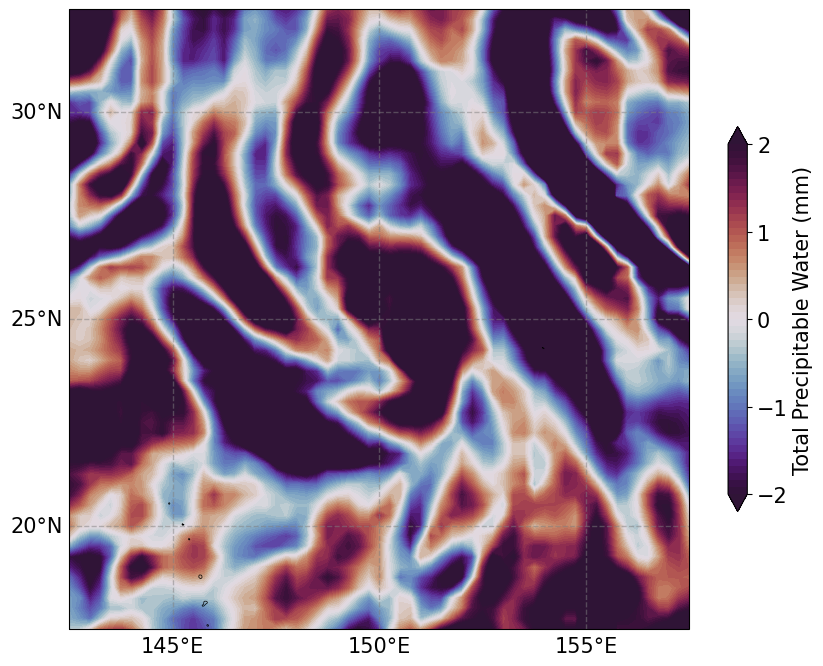

Predicting for interval: 24h


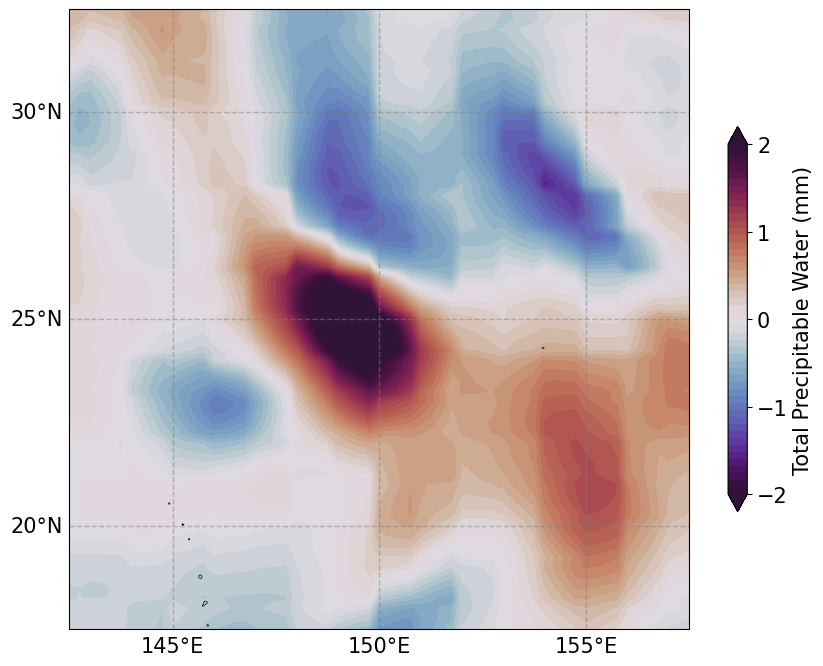

In [183]:
group_size = 20

ens_idx_list = []
    
for ens in ens_list:
    if (target_time in ssv_dict[key_time][ens]):
        ens_idx_list.append(ens)


# 데이터를 추출합니다
# mid_pos = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_idx_list]
tar_pos = [(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_idx_list]
print(f'Number of ensemble members: {len(ens_idx_list)}')
# NumPy 배열로 변환
tar_pos =  np.array(tar_pos)

#타겟 위치의 PCA
corr_pos_tar = np.copy(tar_pos)
corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
pca_tar = PCA(n_components=1)
pca_tar.fit(corr_pos_tar)
pca_tar.mean_[0] = pca_tar.mean_[0] / np.cos(np.radians(pca_tar.mean_[1])) + np.mean(tar_pos[:, 0])
ensemble_mean = np.mean(pca_tar.transform(corr_pos_tar)[:, 0])

#distance 구하기
corr_pos_tar = np.copy(tar_pos)
corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
projection = pca_tar.transform(corr_pos_tar)[:, 0]  # 주축에 투영된 데이터 (1차원)

distances_tar = (projection - ensemble_mean) * 111

# 가장 작은 10개 인덱스 (오름차순 정렬)
smallest_idx = np.argsort(distances_tar)[:group_size]
# 가장 큰 10개 인덱스 (내림차순 정렬)
largest_idx = np.argsort(distances_tar)[-group_size:][::-1]

# ensemble 번호로 변환
southwest_ens = [ens_idx_list[i] for i in smallest_idx]
northeast_ens = [ens_idx_list[i] for i in largest_idx]

print("Smallest 10 ensemble numbers:", southwest_ens)
print("Largest 10 ensemble numbers:", northeast_ens)


input_data_dir = '/home1/jek/Pangu-Weather/input_data/2022/08/28/00UTC'
input_data = np.load(os.path.join(input_data_dir, rf'upper.npy')).astype(np.float32)
lat_what = 45
lon_what = 100
q_input_all = input_data[upper_dict['q'],:, lat_what*4:lat_what*4+lat_end+1,lon_what*4:lon_what*4+lon_end+1]*1000
q_input_col = np.trapz(q_input_all[::-1], x=pres_array[::-1], axis=0)/9.80665/10

q_output_col_1 = q_input_col.copy()  # 초기값 설정
for group_ens in [southwest_ens, northeast_ens]:
    for predict_interval in range(24, 25, 6):
        print(f"Predicting for interval: {predict_interval}h")
        q_output_col = []
        for ens in group_ens:
        # for ens in [1716, 2506]:
            output_data_dir = f'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
            met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid, input_sign = 'n')

            q_output_all = met.met_data('q', level ='all')
            q_output_col.append(np.trapz(q_output_all[::-1], x=pres_array[::-1], axis=0)/9.80665/10)
        
        q_output_col = np.mean(np.array(q_output_col), axis = 0)

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
        # ax.set_extent(extent, crs=proj)
        ax.coastlines('10m', linewidth=0.5)
        ax.set_extent([142.5, 157.5, 17.5, 32.5], crs=proj)
        sax = ax.contourf(
            lon_grid, lat_grid,  q_output_col_1 - q_output_col, cmap='twilight_shifted',
            # transform=proj, levels=np.linspace(30, 70, 51),
            transform=proj, levels=np.linspace(-2, 2, 51),
            extend='both', zorder=-1
        )
        sax_cb = plt.colorbar(sax, ax=ax, orientation='vertical', label='TPW (mm)', shrink=0.5)
        sax_cb.set_label('Total Precipitable Water (mm)', fontsize=15)  # colorbar 자체의 label
        sax_cb.ax.set_yticks(np.linspace(-2, 2, 5))  # y축 눈금 설정
        sax_cb.ax.tick_params(labelsize=15)
        map_gridlines(ax, proj = proj, font_size = 15, gridline_spaces = 5)

        plt.show()
    # break
        q_output_col_1 = q_output_col  # 마지막 결과를 저장하기 위해 변수 이름 변경

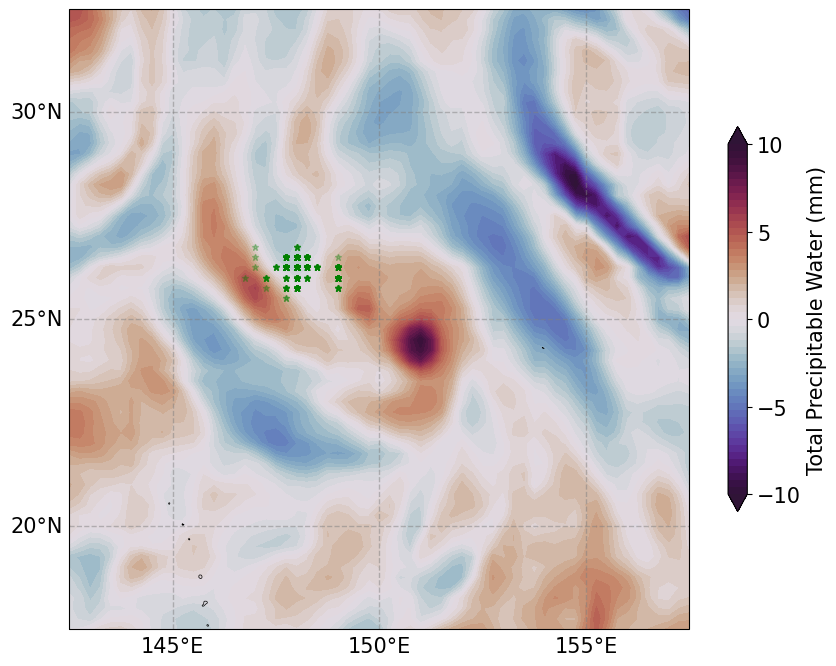

In [178]:


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})


for key_time ,min_position in ssv_dict.items():
    for predict_interval in [24]:
        datetime1 = key_time + timedelta(hours=int(predict_interval))
        mean_lon = []
        mean_lat = []
        for ens in ens_list:
            pred_times = [pos for pos, _ in min_position[ens].items()]
            if datetime1 in pred_times:
                # Find the exact 00UTC prediction for this ensemble and predict_interval
                predicted_pos = min_position[ens].get(datetime1)
                if predicted_pos:
                    ax.plot(predicted_pos['lon'], predicted_pos['lat'],
                            marker='*', markersize=5, color='green',
                            linestyle='None', transform=ax.projection, zorder=10,
                            label=f'Ensemble {ens} 00UTC', alpha = 0.3) # Add a label for clarity
                    
                mean_lon.append(predicted_pos['lon'])
                mean_lat.append(predicted_pos['lat'])

# ax.set_extent(extent, crs=proj)
ax.coastlines('10m', linewidth=0.5)
ax.set_extent([142.5, 157.5, 17.5, 32.5], crs=proj)
sax = ax.contourf(
    lon_grid, lat_grid,  q_input_col- q_output_col, cmap='twilight_shifted',
    transform=proj, levels=np.linspace(-10, 10, 51),
    extend='both', zorder=-1
)
sax_cb = plt.colorbar(sax, ax=ax, orientation='vertical', label='TPW (mm)', shrink=0.5)
sax_cb.set_label('Total Precipitable Water (mm)', fontsize=15)  # colorbar 자체의 label
sax_cb.ax.set_yticks(np.linspace(-10, 10, 5))  # y축 눈금 설정
sax_cb.ax.tick_params(labelsize=15)
map_gridlines(ax, proj = proj, font_size = 15, gridline_spaces = 5)

plt.show()

# MSLP comparison of southwest and northeast groups

mslp_mean: 1010.1454467773438


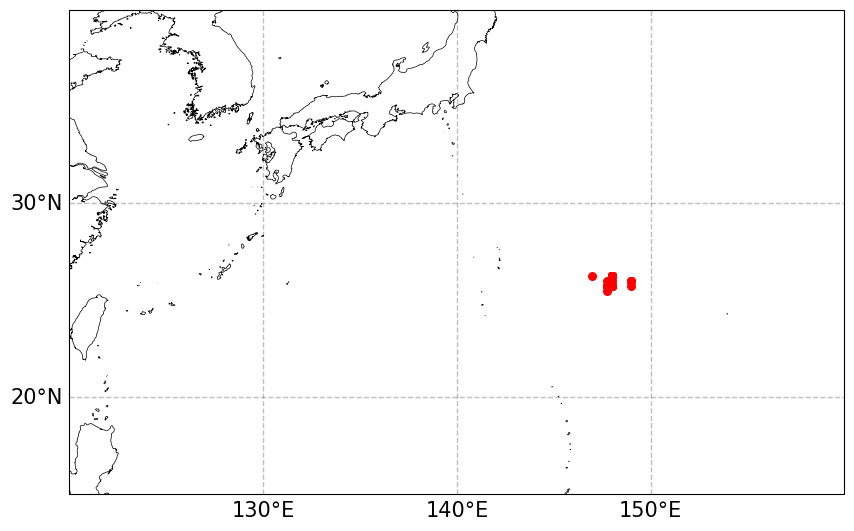

mslp_mean: 1010.2579956054688


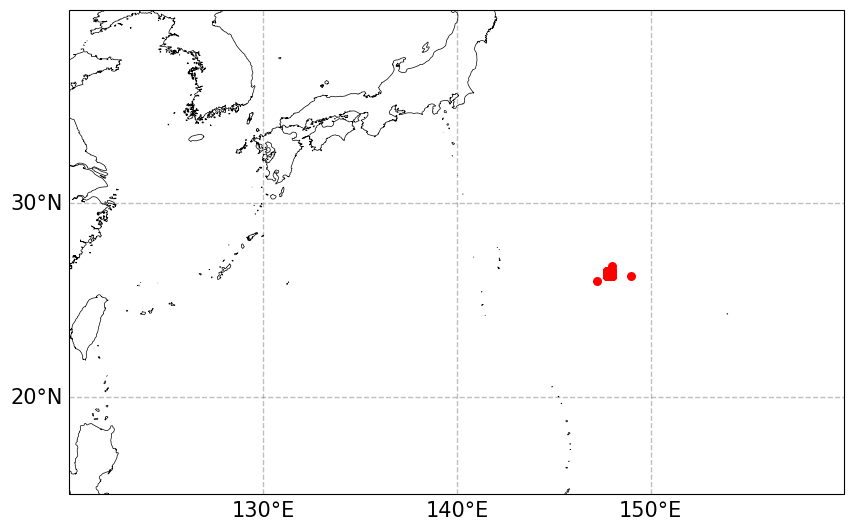

In [149]:
predict_interval = 24  # 예측 시간 설정
mslp_group_list = []
for group_ens in [southwest_ens, northeast_ens]:
    q_output_col = []
    mslp_list = []
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
    ax.set_extent([120, 160, 15, 40], crs=proj)
    ax.coastlines('10m', linewidth=0.5)
    for ens in group_ens:
    # for ens in [1716, 2506]:
        output_data_dir = f'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
        met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid, input_sign = 'n')

        data = met.met_data('MSLP', level ='sf')


        # 해면기압의 로컬 최소값의 위치 찾기
        data_copy = np.copy(data)   #data_copy는 MSLP 정보
        filtered_data = minimum_filter(data_copy, size = 20)
        local_minima = data_copy == filtered_data
        minima_labels, num_features = label(local_minima)
        minima_positions = np.array([np.mean(np.where(minima_labels == i), axis=1) for i in range(1, num_features+1)])
        minima_positions = minima_positions.astype(int)



        # minima_positions가 정수형 인덱스 배열이라고 가정 (N, 2)
        lon_vals = lon_grid[minima_positions[:, 0], minima_positions[:, 1]]
        lat_vals = lat_grid[minima_positions[:, 0], minima_positions[:, 1]]

        # 기준점 (150, 25)와의 거리 계산
        target_lon, target_lat = 150, 25
        distances = np.sqrt((lon_vals - target_lon)**2 + (lat_vals - target_lat)**2)

        # 가장 가까운 index 선택
        closest_idx = np.argmin(distances)
        closest_pos = minima_positions[closest_idx]
        closest_i, closest_j = closest_pos

        # 정확한 위치의 MSLP 값 추출
        closest_mslp = data[closest_i, closest_j]
        mslp_list.append(closest_mslp)

        # 선택된 지점
        closest_lon = lon_vals[closest_idx]
        closest_lat = lat_vals[closest_idx]
        
        ax.scatter(closest_lon, closest_lat, c='red', s=30, label='Closest Minima', transform=proj)
        # ax.scatter(lon_grid[minima_positions[:, 0], minima_positions[:, 1]], lat_grid[minima_positions[:, 0], minima_positions[:, 1]], c='red', s=10, label='Local Minima', transform=proj)
    print(f'mslp_mean: {np.mean(mslp_list)}')
    map_gridlines(ax, proj = proj, font_size = 15)
    plt.show()
    mslp_group_list.append(mslp_list)
    


실제 평균 차이: -0.113
p-value: 0.00861
Observed MSLP mean difference: 0.11 hPa
P-value from permutation test: 0.0044


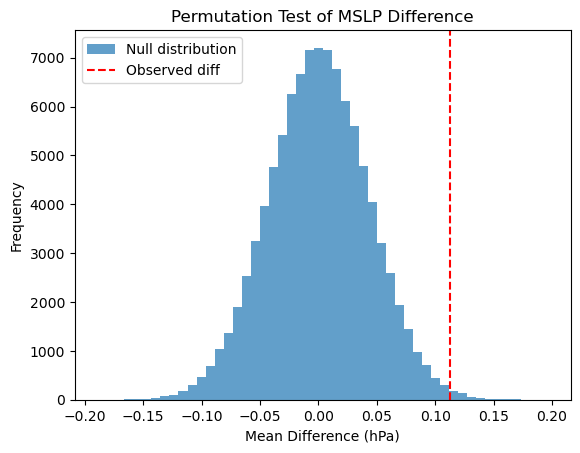

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ens_idx_list = []
for ens in ens_list:
    if (target_time in ssv_dict[key_time][ens]):
        ens_idx_list.append(ens)

total_mslp_list = []
for ens in ens_idx_list:
# for ens in [1716, 2506]:
    output_data_dir = f'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
    met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid, input_sign = 'n')

    data = met.met_data('MSLP', level ='sf')


    # 해면기압의 로컬 최소값의 위치 찾기
    data_copy = np.copy(data)   #data_copy는 MSLP 정보
    filtered_data = minimum_filter(data_copy, size = 20)
    local_minima = data_copy == filtered_data
    minima_labels, num_features = label(local_minima)
    minima_positions = np.array([np.mean(np.where(minima_labels == i), axis=1) for i in range(1, num_features+1)])
    minima_positions = minima_positions.astype(int)



    # minima_positions가 정수형 인덱스 배열이라고 가정 (N, 2)
    lon_vals = lon_grid[minima_positions[:, 0], minima_positions[:, 1]]
    lat_vals = lat_grid[minima_positions[:, 0], minima_positions[:, 1]]

    # 기준점 (150, 25)와의 거리 계산
    target_lon, target_lat = 150, 25
    distances = np.sqrt((lon_vals - target_lon)**2 + (lat_vals - target_lat)**2)

    # 가장 가까운 index 선택
    closest_idx = np.argmin(distances)
    closest_pos = minima_positions[closest_idx]
    closest_i, closest_j = closest_pos

    # 정확한 위치의 MSLP 값 추출
    closest_mslp = data[closest_i, closest_j]
    total_mslp_list.append(closest_mslp)




group_size = 50
n_iterations = 10000


# 실제 두 그룹 평균 차이
observed_diff = np.abs(np.mean(mslp_group_list[0]) - np.mean(mslp_group_list[1]))

# 모든 mslp를 통합
combined = np.array(total_mslp_list)
assert len(combined) == 2 * group_size

# permutation test
diffs = []
for _ in range(n_iterations):
    np.random.shuffle(combined)
    group1 = combined[:group_size]
    group2 = combined[group_size:]
    diff = np.abs(np.mean(group1) - np.mean(group2))
    diffs.append(diff)


group1 = np.array(mslp_group_list[0])
group2 = np.array(mslp_group_list[1])
combined = np.array(total_mslp_list)  # 예: 전체 4000 ensemble 멤버의 mslp

group_size = len(group1)
true_diff = np.mean(group1) - np.mean(group2)

n_permutations = 10000
diffs = []

for _ in range(n_permutations):
    sample = np.random.choice(combined, 2 * group_size, replace=False)
    fake1 = sample[:group_size]
    fake2 = sample[group_size:]
    diffs.append(np.mean(fake1) - np.mean(fake2))

diffs = np.array(diffs)
p_value = (np.abs(diffs) >= np.abs(true_diff)).mean()

print(f"실제 평균 차이: {true_diff:.3f}")
print(f"p-value: {p_value:.5f}")

# p-value: 실제 차이보다 큰 샘플 비율
diffs = np.array(diffs)
p_value = np.mean(diffs >= observed_diff)

# 결과 출력
print(f"Observed MSLP mean difference: {observed_diff:.2f} hPa")
print(f"P-value from permutation test: {p_value:.4f}")

# 시각화
plt.hist(diffs, bins=50, alpha=0.7, label='Null distribution')
plt.axvline(observed_diff, color='red', linestyle='--', label='Observed diff')
plt.xlabel('Mean Difference (hPa)')
plt.ylabel('Frequency')
plt.title('Permutation Test of MSLP Difference')
plt.legend()
plt.show()


In [101]:
import numpy as np

for predict_interval in range(48, 49, 6):
    print(f'Processing {predict_interval} hours forecast...')
    datetime1 = key_time + timedelta(hours=int(predict_interval))
    
    ens_idx_list = []
        
    for ens in ens_list[:]:
        if (datetime1 in ssv_dict[key_time][ens]):
            ens_idx_list.append(ens)
    
    ens_idx_list
    # 데이터를 추출합니다
    mid_pos = np.array([(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_idx_list])

    
    # 위도(lat)는 mid_pos의 두 번째 column (index=1)
    latitudes = mid_pos[:, 1]

    # 위도가 가장 높은 10개 index 추출 (내림차순 정렬 후 상위 10개)
    highest_10_indices = np.argsort(latitudes)[-10:][::-1]
    highest_10 = ens_idx_list[highest_10_indices]

    # 위도가 가장 낮은 10개 index 추출 (오름차순 정렬 후 하위 10개)
    lowest_10_indices = np.argsort(latitudes)[:10]
    lowest_10 = ens_idx_list[lowest_10_indices]

    print("위도가 가장 높은 10개:")
    print(highest_10)

    print("위도가 가장 낮은 10개:")
    print(lowest_10)

Processing 48 hours forecast...
위도가 가장 높은 10개:
[2506 1440  800 2480  639  955 2382 2957 2556   52]
위도가 가장 낮은 10개:
[1716  631 1363  742  192 2135 3413  224  784  847]
